# About this notebook & directory
As a part of Team redzone which belongs to Aiffel Pusan 2-ki, formed to participates aiffelthon 2022 NOV - DEC. But in korean mostly. This cvae based on the [elemisi's cvae on github](https://github.com/EleMisi/ConditionalVAE/).

# 여기서 할일
2022-11-28  
out of memory문제인지 에러가 발생하고 있다. 어떡하지?

2022-11-26 새로 만듬
일단 혜선님이 1차로 올린 이미지를 가지고 generation을 해 본다.
- 그 전에 전처리를 해야 한다. 이미지 경로, 속성(여기서는 센서 측정 데이터와 라벨)을 csv로 저장하자.  
- 또 elemisi의 전처리 과정을 테스트해본다. (src/celeba.py)

## 사이즈에 대한 고려 
여기서는 먼저 이미지 사이즈에 대한 고려가 있어야 한다. 이 코드에서는 $64\times64$ 크기의 이미지를 4개의 Conv2D layer를 통과시켜 $4\times4$마지막에는 256개의 filter에서 256개의 latent vector와 fc-layer로 연결한다.  
이 때 이 fc-layer의 parameter는 $4\times4\times256\times256=1,048,576$이다. 그런데 지금 우리의 경우 $(1192\times1216)$이미지를 한 번에 네 장 쓰고 있어 그대로 하면 371,064,832 개로 parameter가 증가할 것이다. 이것은 차이가 너무 크기 때문에 일단 2D maxpool layer를 앞뒤로 배치하도록 하겠다. 근데 이건 celeba.py가 아니고 다른 파일이다.  

### imported source 고치기
elemisi/ConditionalVAE 에서 적용하기 위해 고칠 점이 많았다.
- 이미지 사이즈 관련: 원래 (64, 64)사이즈인 이미지를 늘리다 보니 고칠 점이 많습니다.
    - src/ConvolutionalCondVAE.py: 
        - line 211  
            ```python
            reconstr_loss = np.prod((1024,1024)) *\
                        tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(input_img),\
                                                            tf.keras.backend.flatten(recon_img)) # over weighted MSE```
        - line 186, 196 ```python 
            class ConvCVAE() : def __init__(): ```
                - 여기선 image_dim 을 [1024, 1024, 6]으로 수정하는데 밑에 default 값 무시하고 그냥 넣어줘서 두 번 수정함
        - decoder의 마지막 필터 : 인풋 종류에 따라 filter 6개가 돼야 한다.
    - src/utils.py: utils for plotting 부분 엄청 고쳐야 하는데 아직 안고침
    - src/celeba.py: 이건 고칠 것이 많아서 아예 밑에 따로 빼서 썼다.
    - init, load, preprocess, get_images 알맞게 고쳤고 shuffle은 일단 disable시켜버렸다. self.img_paths, self.train_img_ids 를 붙여서 셔플해야 하는데 img_paths는 train/test 분리가 안돼있기 때문에 복잡해지기 때문이다.

### 테스트 디멘션 변경시 바꿔야 할 것들
- src/ConvolutionalCondVAE.py에서 reconstr_loss = np.prod((1024, 1024)) ...
- class Dataset()

# 전처리

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
sample_chls=os.listdir('sample_img/imgCrop_CHL')
sample_chls=[os.path.join('sample_img/imgCrop_CHL/', i) for i in sample_chls]
sample_ris=os.listdir('sample_img/imgCrop_RI')
sample_ris=[os.path.join('sample_img/imgCrop_RI/', i) for i in sample_ris]
#print(sample_chls)

In [2]:
sample_chls=os.listdir('sample_img/imgCrop_CHL')
sample_ris=os.listdir('sample_img/imgCrop_RI')


In [3]:
print(sample_chls[0], sample_ris[0])

20200914_12_CHL.JPG.jpg 20190830_14_RI.JPG.jpg


In [4]:
import pandas as pd
sample_chls_fn_split=[list(i.split('.')[0].split('_'))+[i] for i in sample_chls]
sample_ris_fn_split=[list(i.split('.')[0].split('_'))+[i] for i in sample_ris]

In [5]:
#sample_chls_fn_split

In [6]:
sample_chls_df=pd.DataFrame(sample_chls_fn_split, columns=['date', 'hour', 'product','file'])

In [7]:
sample_chls_df

,date,hour,product,file
0,20200914,12,CHL,20200914_12_CHL.JPG.jpg
1,20200917,12,CHL,20200917_12_CHL.JPG.jpg
2,20200929,16,CHL,20200929_16_CHL.JPG.jpg
3,20200915,15,CHL,20200915_15_CHL.JPG.jpg
4,20200919,11,CHL,20200919_11_CHL.JPG.jpg
...,...,...,...,...
381,20200924,09,CHL,20200924_09_CHL.JPG.jpg
382,20200905,14,CHL,20200905_14_CHL.JPG.jpg
383,20190829,09,CHL,20190829_09_CHL.JPG.jpg
384,20200921,12,CHL,20200921_12_CHL.JPG.jpg


In [8]:
sample_ris_df=pd.DataFrame(sample_ris_fn_split, columns=['date', 'hour', 'product','file'])

In [9]:
sample_ris_df

,date,hour,product,file
0,20190830,14,RI,20190830_14_RI.JPG.jpg
1,20190823,09,RI,20190823_09_RI.JPG.jpg
2,20200908,10,RI,20200908_10_RI.JPG.jpg
3,20200906,15,RI,20200906_15_RI.JPG.jpg
4,20190901,15,RI,20190901_15_RI.JPG.jpg
...,...,...,...,...
386,20200923,09,RI,20200923_09_RI.JPG.jpg
387,20200914,16,RI,20200914_16_RI.JPG.jpg
388,20190825,15,RI,20190825_15_RI.JPG.jpg
389,20200902,14,RI,20200902_14_RI.JPG.jpg


In [10]:
sample_ris_df.dropna(inplace=True)
sample_ris_df['file']=sample_ris_df['file'].apply(lambda x:os.path.join('sample_img/imgCrop_RI/',x))
sample_ris_df

,date,hour,product,file
0,20190830,14,RI,sample_img/imgCrop_RI/20190830_14_RI.JPG.jpg
1,20190823,09,RI,sample_img/imgCrop_RI/20190823_09_RI.JPG.jpg
2,20200908,10,RI,sample_img/imgCrop_RI/20200908_10_RI.JPG.jpg
3,20200906,15,RI,sample_img/imgCrop_RI/20200906_15_RI.JPG.jpg
4,20190901,15,RI,sample_img/imgCrop_RI/20190901_15_RI.JPG.jpg
...,...,...,...,...
386,20200923,09,RI,sample_img/imgCrop_RI/20200923_09_RI.JPG.jpg
387,20200914,16,RI,sample_img/imgCrop_RI/20200914_16_RI.JPG.jpg
388,20190825,15,RI,sample_img/imgCrop_RI/20190825_15_RI.JPG.jpg
389,20200902,14,RI,sample_img/imgCrop_RI/20200902_14_RI.JPG.jpg


In [11]:
sample_chls_df.dropna(inplace=True)
sample_chls_df['file']=sample_chls_df['file'].apply(lambda x:os.path.join('sample_img/imgCrop_CHL/',x))
sample_chls_df

,date,hour,product,file
0,20200914,12,CHL,sample_img/imgCrop_CHL/20200914_12_CHL.JPG.jpg
1,20200917,12,CHL,sample_img/imgCrop_CHL/20200917_12_CHL.JPG.jpg
2,20200929,16,CHL,sample_img/imgCrop_CHL/20200929_16_CHL.JPG.jpg
3,20200915,15,CHL,sample_img/imgCrop_CHL/20200915_15_CHL.JPG.jpg
4,20200919,11,CHL,sample_img/imgCrop_CHL/20200919_11_CHL.JPG.jpg
...,...,...,...,...
381,20200924,09,CHL,sample_img/imgCrop_CHL/20200924_09_CHL.JPG.jpg
382,20200905,14,CHL,sample_img/imgCrop_CHL/20200905_14_CHL.JPG.jpg
383,20190829,09,CHL,sample_img/imgCrop_CHL/20190829_09_CHL.JPG.jpg
384,20200921,12,CHL,sample_img/imgCrop_CHL/20200921_12_CHL.JPG.jpg


In [12]:
sample_chls_df.sort_values(by=['date', 'hour'], inplace=True)
sample_ris_df.sort_values(by=['date', 'hour'], inplace=True)

In [13]:
sample_ris_df['year']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_ris_df['mm']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_ris_df['dd']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_ris_df['hh']=sample_ris_df['hour'].astype('int')


In [14]:
sample_ris_df

,date,hour,product,file,year,mm,dd,hh
311,20190820,09,RI,sample_img/imgCrop_RI/20190820_09_RI.JPG.jpg,2019,8,20,9
352,20190820,10,RI,sample_img/imgCrop_RI/20190820_10_RI.JPG.jpg,2019,8,20,10
312,20190820,11,RI,sample_img/imgCrop_RI/20190820_11_RI.JPG.jpg,2019,8,20,11
75,20190820,12,RI,sample_img/imgCrop_RI/20190820_12_RI.JPG.jpg,2019,8,20,12
379,20190820,13,RI,sample_img/imgCrop_RI/20190820_13_RI.JPG.jpg,2019,8,20,13
...,...,...,...,...,...,...,...,...
23,20200930,12,RI,sample_img/imgCrop_RI/20200930_12_RI.JPG.jpg,2020,9,30,12
243,20200930,13,RI,sample_img/imgCrop_RI/20200930_13_RI.JPG.jpg,2020,9,30,13
124,20200930,14,RI,sample_img/imgCrop_RI/20200930_14_RI.JPG.jpg,2020,9,30,14
170,20200930,15,RI,sample_img/imgCrop_RI/20200930_15_RI.JPG.jpg,2020,9,30,15


In [15]:
sample_ris_df.drop(columns=['date', 'hour'], inplace=True)
sample_ris_df.reset_index(drop=True, inplace=True)
sample_ris_df

,product,file,year,mm,dd,hh
0,RI,sample_img/imgCrop_RI/20190820_09_RI.JPG.jpg,2019,8,20,9
1,RI,sample_img/imgCrop_RI/20190820_10_RI.JPG.jpg,2019,8,20,10
2,RI,sample_img/imgCrop_RI/20190820_11_RI.JPG.jpg,2019,8,20,11
3,RI,sample_img/imgCrop_RI/20190820_12_RI.JPG.jpg,2019,8,20,12
4,RI,sample_img/imgCrop_RI/20190820_13_RI.JPG.jpg,2019,8,20,13
...,...,...,...,...,...,...
386,RI,sample_img/imgCrop_RI/20200930_12_RI.JPG.jpg,2020,9,30,12
387,RI,sample_img/imgCrop_RI/20200930_13_RI.JPG.jpg,2020,9,30,13
388,RI,sample_img/imgCrop_RI/20200930_14_RI.JPG.jpg,2020,9,30,14
389,RI,sample_img/imgCrop_RI/20200930_15_RI.JPG.jpg,2020,9,30,15


In [16]:
# do the same for CHLs 

sample_chls_df['year']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_chls_df['mm']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_chls_df['dd']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_chls_df['hh']=sample_chls_df['hour'].astype('int')
sample_chls_df.drop(columns=['date', 'hour'], inplace=True)
sample_chls_df.reset_index(drop=True, inplace=True)
sample_chls_df

,product,file,year,mm,dd,hh
0,CHL,sample_img/imgCrop_CHL/20190820_09_CHL.JPG.jpg,2019,8,20,9
1,CHL,sample_img/imgCrop_CHL/20190820_10_CHL.JPG.jpg,2019,8,20,10
2,CHL,sample_img/imgCrop_CHL/20190820_11_CHL.JPG.jpg,2019,8,20,11
3,CHL,sample_img/imgCrop_CHL/20190820_12_CHL.JPG.jpg,2019,8,20,12
4,CHL,sample_img/imgCrop_CHL/20190820_13_CHL.JPG.jpg,2019,8,20,13
...,...,...,...,...,...,...
379,CHL,sample_img/imgCrop_CHL/20200930_12_CHL.JPG.jpg,2020,9,30,12
380,CHL,sample_img/imgCrop_CHL/20200930_13_CHL.JPG.jpg,2020,9,30,13
381,CHL,sample_img/imgCrop_CHL/20200930_14_CHL.JPG.jpg,2020,9,30,14
382,CHL,sample_img/imgCrop_CHL/20200930_15_CHL.JPG.jpg,2020,9,30,15



## 데이터 통합
아무튼 날짜를 기준으로 두 자료와 수치 데이터를 통합해야 한다. 그런데 CHL만 없는 데 돌릴 수는 없는 노릇이므로 RI만 없는 것은 취하고 아닌 것은 뺀다. 그리고 KST로 통일한다.  
다음 코드로 확인해본 결과 CHL쪽 날자가 몇 개 빈다. 왜일까?   
그리고 통합 데이터셋은 날짜를 떼어놔서 다시 만들어야 한다.  
```python
sample_chls_df.groupby(['year', 'mm', 'dd']).count()
sample_ris_df.groupby(['year', 'mm', 'dd']).count()
```

In [27]:
sensory=os.path.join(os.getenv('HOME'), 'aiffel/aiffelthon/sample_data/observe_train_refined_with_datetime.csv')
sensory=pd.read_csv(sensory)
sensory

,Unnamed: 0,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,기온(°C).1,수온(°C).1,...,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생,interpolated,year,mm,dd,hh
0,39,-0.846358,0.903430,-0.460595,-0.297487,-0.124668,-1.539878,0.752017,-0.658575,-0.665820,...,1.551810,-0.364254,-0.500266,-0.112367,0.0,False,2017,1,2,16
1,40,-0.308964,0.861089,-0.404756,-0.276128,-0.124668,-1.661737,0.652532,-0.588377,-0.620489,...,-1.337830,-0.391642,-0.519119,-0.112367,0.0,1.0,2017,1,2,17
2,41,-0.428385,0.945770,-0.348918,-0.297487,-0.124668,-1.448484,0.534960,-0.616456,-0.643154,...,1.378432,-0.377948,-0.519119,-0.112367,0.0,False,2017,1,2,18
3,42,-0.338819,0.827217,-0.293080,-0.404279,-0.124668,-1.539878,0.652532,-0.546258,-0.665820,...,1.386688,-0.323173,-0.519119,-0.112367,0.0,False,2017,1,2,19
4,43,0.168719,1.064324,-0.320999,-0.468355,-0.124668,0.074754,0.842458,-0.447980,-0.688485,...,-1.329574,-0.336867,-0.500266,-0.112367,0.0,False,2017,1,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,50370,-1.712158,0.115895,0.879527,1.218967,-0.124668,-1.082907,-0.405622,0.899828,1.260715,...,-1.329574,0.881887,1.196504,-0.112367,0.0,False,2022,9,30,19
50332,50371,-1.353896,0.183640,0.893486,1.176250,-0.124668,-0.991512,-0.360402,0.857709,1.238050,...,-1.222244,0.553234,1.026827,-0.112367,0.0,False,2022,9,30,20
50333,50372,-1.353896,0.454619,0.879527,1.176250,-0.124668,-1.143836,-0.360402,0.857709,1.215385,...,1.477505,0.347826,0.970268,-0.112367,0.0,False,2022,9,30,21
50334,50373,-1.234475,0.573173,0.837648,1.261684,-0.124668,-1.418019,-0.043860,0.815590,1.215385,...,1.361919,0.690173,0.932562,-0.112367,0.0,False,2022,9,30,22


In [30]:
if sensory.columns[0]=='Unnamed: 0':
    sensory.drop(columns=['Unnamed: 0'], inplace=True)
sensory.columns

Index(['풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s).1',
       '풍향(deg).1', '기온(°C).1', '수온(°C).1', '강수량(mm).1', '풍속(m/s).2',
       '풍향(deg).2', '기온(°C).2', '수온(°C).2', '강수량(mm).2', '풍속(m/s).3',
       '풍향(deg).3', '기온(°C).3', '수온(°C).3', '강수량(mm).3', '풍속(m/s).4',
       '풍향(deg).4', '기온(°C).4', '수온(°C).4', '강수량(mm).4', '적조발생',
       'interpolated', 'year', 'mm', 'dd', 'hh'],
      dtype='object')

In [31]:
dt_index=['year', 'mm', 'dd', 'hh']
sensory[dt_index]

,year,mm,dd,hh
0,2017,1,2,16
1,2017,1,2,17
2,2017,1,2,18
3,2017,1,2,19
4,2017,1,2,20
...,...,...,...,...
50331,2022,9,30,19
50332,2022,9,30,20
50333,2022,9,30,21
50334,2022,9,30,22


In [32]:
sample_chls_df[dt_index]

,year,mm,dd,hh
0,2019,8,20,9
1,2019,8,20,10
2,2019,8,20,11
3,2019,8,20,12
4,2019,8,20,13
...,...,...,...,...
379,2020,9,30,12
380,2020,9,30,13
381,2020,9,30,14
382,2020,9,30,15


In [33]:
sample_ris_df[dt_index]

,year,mm,dd,hh
0,2019,8,20,9
1,2019,8,20,10
2,2019,8,20,11
3,2019,8,20,12
4,2019,8,20,13
...,...,...,...,...
386,2020,9,30,12
387,2020,9,30,13
388,2020,9,30,14
389,2020,9,30,15


In [46]:
print(sensory[dt_index+[sensory.columns[2]]][150:200])

     year  mm  dd  hh    기온(°C)
150  2017   1   8  22 -0.558312
151  2017   1   8  23 -0.558312
152  2017   1   9   0 -0.656029
153  2017   1   9   1 -0.767706
154  2017   1   9   2 -0.739787
155  2017   1   9   3 -0.781665
156  2017   1   9   4 -0.725827
157  2017   1   9   5 -0.753746
158  2017   1   9   6 -0.837504
159  2017   1   9   7 -0.907302
160  2017   1   9   8 -0.935221
161  2017   1   9   9 -0.991059
162  2017   1   9  10 -1.018979
163  2017   1   9  11 -1.046898
164  2017   1   9  12 -1.018979
165  2017   1   9  13 -1.032938
166  2017   1   9  14 -1.018979
167  2017   1   9  15 -0.991059
168  2017   1   9  16 -0.921261
169  2017   1   9  17 -0.907302
170  2017   1   9  18 -0.879383
171  2017   1   9  19 -0.865423
172  2017   1   9  20 -0.921261
173  2017   1   9  21 -1.032938
174  2017   1   9  22 -1.144615
175  2017   1   9  23 -1.214413
176  2017   1  10   0 -1.242332
177  2017   1  10   1 -1.312130
178  2017   1  10   2 -1.312130
179  2017   1  10   3 -1.326090
180  201

In [50]:
sample_chls_df[dt_index].apply(lambda x: x.dtype)

year    int64
mm      int64
dd      int64
hh      int64
dtype: object

In [99]:
merged_list=[] #will generate merge dataframe
tot_row=0
for ri_row in sample_ris_df.itertuples():
    ri_dt=ri_row[-4:]
    matched=0
    for chl_row in sample_chls_df.itertuples():
        chl_dt=chl_row[-4:]
        if (ri_dt==chl_dt):
            #print('{} exists in both df'.format(ri_dt))
            matched=1
            for sensory_row in sensory.itertuples():
                sensory_dt=sensory_row[-4:]
                if sensory_dt==ri_dt:
                    merged_list.append(ri_row[2:-4]+chl_row[2:-4]+sensory_row[1:-5])
                    tot_row+=1
                    matched=2
    if matched==0:
        print('no matched chl data found for ', ri_dt)
    elif matched==1:
        print('no matched sensroy data found for', ri_dt)
        
                    
print(tot_row)
        

no matched chl data found for  (2019, 9, 6, 9)
no matched chl data found for  (2019, 9, 6, 10)
no matched chl data found for  (2019, 9, 6, 11)
no matched chl data found for  (2019, 9, 6, 12)
no matched chl data found for  (2019, 9, 6, 13)
no matched chl data found for  (2019, 9, 6, 15)
no matched chl data found for  (2019, 9, 6, 16)
no matched chl data found for  (2020, 9, 4, 9)
383


## 시간 전처리
pandas df에서 year, mm, dd, hh columns 읽어와서 리스트 하나로 저장하기
이렇게 하면 iterrows 같은 걸 쓸 때 data type이 보존되지 않는 문제가 있다. 그래서 안썼는데 timestamp 말고 list로 저장해놓으면 괜찮지 않을까 아님 그냥 이대로 할까?

2

In [88]:
for sensory_row in sensory[:4].itertuples():
    print(sensory_row[-4:])

(2017, 1, 2, 16)
(2017, 1, 2, 17)
(2017, 1, 2, 18)
(2017, 1, 2, 19)


In [104]:
sensory.columns[-5:].tolist()

['interpolated', 'year', 'mm', 'dd', 'hh']

In [106]:
merged_df=pd.DataFrame(merged_list, columns=['RI_file', 'CHL_file']+sensory.columns[:-5].tolist())

In [122]:
merged_df.to_csv("list_attr.csv")

In [107]:
merged_df

,RI_file,CHL_file,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,기온(°C).1,...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,sample_img/imgCrop_RI/20190820_09_RI.JPG.jpg,sample_img/imgCrop_CHL/20190820_09_CHL.JPG.jpg,0.825533,-1.061174,1.437910,1.688854,-0.124668,0.714514,-1.264808,1.363137,...,-1.065967,1.449012,1.602683,-0.150869,-0.223053,-0.759902,1.347478,1.290769,-0.112367,1.0
1,sample_img/imgCrop_RI/20190820_10_RI.JPG.jpg,sample_img/imgCrop_CHL/20190820_10_CHL.JPG.jpg,0.765822,-1.086578,1.437910,1.624778,-0.124668,1.049626,-1.409513,1.180621,...,-1.030813,1.435203,1.564615,-0.150869,-0.131372,-0.817695,1.361172,1.385035,-0.112367,1.0
2,sample_img/imgCrop_RI/20190820_11_RI.JPG.jpg,sample_img/imgCrop_CHL/20190820_11_CHL.JPG.jpg,1.183795,-1.044238,1.479789,1.731571,-0.124668,0.440331,-1.346204,1.236780,...,-1.048390,1.435203,1.545582,-0.150869,-0.161932,-0.817695,1.333784,1.403888,-0.112367,1.0
3,sample_img/imgCrop_RI/20190820_12_RI.JPG.jpg,sample_img/imgCrop_CHL/20190820_12_CHL.JPG.jpg,1.243505,-1.052706,1.465830,1.774288,-0.124668,-0.138499,-1.020618,1.321018,...,-0.960506,1.407586,1.507514,-0.150869,0.128389,-0.751646,1.347478,1.403888,-0.112367,1.0
4,sample_img/imgCrop_RI/20190820_13_RI.JPG.jpg,sample_img/imgCrop_CHL/20190820_13_CHL.JPG.jpg,1.273360,-0.993429,1.451870,1.795646,-0.124668,-0.290823,-0.975398,1.236780,...,-0.942929,1.435203,1.507514,-0.150869,0.418711,-0.685597,1.361172,1.403888,-0.112367,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,sample_img/imgCrop_RI/20200930_12_RI.JPG.jpg,sample_img/imgCrop_CHL/20200930_12_CHL.JPG.jpg,-0.398530,-1.323686,0.781809,1.133533,-0.124668,0.409866,-1.409513,0.520757,...,-1.232947,0.703345,0.822295,-0.150869,0.143669,-1.222244,0.498459,1.045680,-0.112367,0.0
379,sample_img/imgCrop_RI/20200930_13_RI.JPG.jpg,sample_img/imgCrop_CHL/20200930_13_CHL.JPG.jpg,-0.607516,-1.391430,0.767850,1.133533,-0.124668,0.470796,-1.391425,0.520757,...,-1.250523,0.744771,0.841329,-0.150869,0.082549,-1.288293,0.703866,1.045680,-0.112367,0.0
380,sample_img/imgCrop_RI/20200930_14_RI.JPG.jpg,sample_img/imgCrop_CHL/20200930_14_CHL.JPG.jpg,-0.517951,-1.239004,0.823688,1.154891,-0.124668,0.379401,-1.472821,0.520757,...,-0.969294,0.772388,0.860363,-0.150869,0.113109,-1.354342,0.936662,1.045680,-0.112367,0.0
381,sample_img/imgCrop_RI/20200930_15_RI.JPG.jpg,sample_img/imgCrop_CHL/20200930_15_CHL.JPG.jpg,-0.637371,-1.111983,0.837648,1.090816,-0.124668,0.166148,-1.463777,0.534796,...,-0.969294,0.800006,0.860363,-0.150869,0.235350,1.510530,0.964050,1.045680,-0.112367,0.0


# 학습시키기
여기서부터 [elemisi/ConditionalVAE](https://github.com/EleMisi/ConditionalVAE) 의 코드를 적극적으로 사용한다. 먼저 포함된 이미지 전처리 과정이 필요한지 따져본다.

## opencv관련 전처리 부분 확인

elemisi의 깃허브에서 전처리를 하는 부분 (celeba.py)이다. 전처리 다음에는 그대로 쓸 것이기 때문에 이게 필요한지 테스트 해본다.
```python
img = cv2.imread(image_path)
img = img[y:y+img_size, x:x+img_size]
img = cv2.resize(img, (img_resize, img_resize))
img = np.array(img, dtype='float32')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img /= 255.0 # Normalization to [0.,1.]
```

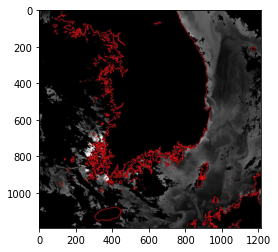

In [118]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread(merged_df.sample(1).RI_file.values[0])
img = np.array(img, dtype='float32')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img /= 255.0 # Normalization to [0.,1.]
plt.imshow(img)

In [119]:
img.shape

(1192, 1216, 3)

# elemisi/CVAE 뜯어고치기
자세한 변경점은 문서 앞부분에 써놨다.


### changes
```python
__init__()
    self.train_img_ids, self.test_img_ids, self.img_paths, self.attributes = self.load(train_size)
    self.path_cols = ['RI_file', 'CHL_file']
```


In [36]:

import numpy as np
a=np.zeros([5,5,3])
b=np.zeros([5,5,3])
np.concatenate((a,b),axis=-1).shape

(5, 5, 6)

In [65]:
df

,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s).1,풍향(deg).1,기온(°C).1,수온(°C).1,강수량(mm).1,...,풍향(deg).3,기온(°C).3,수온(°C).3,강수량(mm).3,풍속(m/s).4,풍향(deg).4,기온(°C).4,수온(°C).4,강수량(mm).4,적조발생
0,0.825533,-1.061174,1.437910,1.688854,-0.124668,0.714514,-1.264808,1.363137,1.668687,-0.134178,...,-1.065967,1.449012,1.602683,-0.150869,-0.223053,-0.759902,1.347478,1.290769,-0.112367,1.0
1,0.765822,-1.086578,1.437910,1.624778,-0.124668,1.049626,-1.409513,1.180621,1.736682,-0.134178,...,-1.030813,1.435203,1.564615,-0.150869,-0.131372,-0.817695,1.361172,1.385035,-0.112367,1.0
2,1.183795,-1.044238,1.479789,1.731571,-0.124668,0.440331,-1.346204,1.236780,1.827343,-0.134178,...,-1.048390,1.435203,1.545582,-0.150869,-0.161932,-0.817695,1.333784,1.403888,-0.112367,1.0
3,1.243505,-1.052706,1.465830,1.774288,-0.124668,-0.138499,-1.020618,1.321018,1.850008,-0.134178,...,-0.960506,1.407586,1.507514,-0.150869,0.128389,-0.751646,1.347478,1.403888,-0.112367,1.0
4,1.273360,-0.993429,1.451870,1.795646,-0.124668,-0.290823,-0.975398,1.236780,1.850008,-0.134178,...,-0.942929,1.435203,1.507514,-0.150869,0.418711,-0.685597,1.361172,1.403888,-0.112367,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,-0.398530,-1.323686,0.781809,1.133533,-0.124668,0.409866,-1.409513,0.520757,0.263450,-0.134178,...,-1.232947,0.703345,0.822295,-0.150869,0.143669,-1.222244,0.498459,1.045680,-0.112367,0.0
379,-0.607516,-1.391430,0.767850,1.133533,-0.124668,0.470796,-1.391425,0.520757,0.331445,-0.134178,...,-1.250523,0.744771,0.841329,-0.150869,0.082549,-1.288293,0.703866,1.045680,-0.112367,0.0
380,-0.517951,-1.239004,0.823688,1.154891,-0.124668,0.379401,-1.472821,0.520757,0.354110,-0.134178,...,-0.969294,0.772388,0.860363,-0.150869,0.113109,-1.354342,0.936662,1.045680,-0.112367,0.0
381,-0.637371,-1.111983,0.837648,1.090816,-0.124668,0.166148,-1.463777,0.534796,0.331445,-0.134178,...,-0.969294,0.800006,0.860363,-0.150869,0.235350,1.510530,0.964050,1.045680,-0.112367,0.0


In [5]:

import pandas as pd
file_path = "list_attr.csv"
df = pd.read_csv(file_path, index_col = 0)
attributes = [x for x in df.columns] 

In [16]:
file_path = "list_attr.csv"
path_cols = ['RI_file', 'CHL_file']
df = pd.read_csv(file_path, index_col = 0)
df.drop(columns=path_cols, inplace=True)

attributes = [x for x in df.columns] 
od = OrderedDict(df.to_dict('index'))

img_ids = OrderedDict()
for k,v in od.items():
    img_id=[np.float32(x) for x in v.values()]
    img_ids[k] = img_id
    
list_img_ids = list(img_ids.items())
#print(list_img_ids)

## __RUNS INDEPENDENTLY__ BELOW THIS

In [8]:
from elemisi_cvae.src.utils import save_data #modified accroding to the path to the utils.py.

In [9]:
from collections import OrderedDict
import cv2
from tensorflow.keras.utils import Sequence
import math
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

class Dataset(Sequence):

    def __init__(self, train_size, batch_size, mode = 'train', save_test_set = False):
        self.path_cols = ['RI_file', 'CHL_file']
        self.train_img_ids, self.test_img_ids, self.img_paths, self.attributes = self.load(train_size)
        self.batch_size = batch_size
        self.mode = mode
        self.train_size = len(self.train_img_ids)
        if save_test_set:
            self.save_test_set()


    def load(self, train_dim):
        """ 
        Loads all image IDs and the attributes and splits the dataset into training set and test set.
            
            Returns:
                    - train_img_ids [list]
                    - test_img_ids [list]
                    - attributes [list]
            
        """

        print("Loading images id and attributes...")

        file_path = "list_attr.csv"
        df = pd.read_csv(file_path, index_col = 0)
        paths_df = df[self.path_cols]
        df.drop(columns=self.path_cols, inplace=True)
        
        attributes = [x for x in df.columns] 
        od = OrderedDict(df.to_dict('index'))
        paths_od = paths_df.to_numpy()#OrderedDict(paths_df.to_dict('index'))
        img_ids = OrderedDict()
        for k,v in od.items():
            img_id=[np.float32(x) for x in v.values()]
            img_ids[k] = img_id
        print("img_ids: {} \nAttributes: {} \n".format(len(img_ids), len(attributes)))

        #Splitting
        print("Splitting dataset...\n")
        n_train = int(len(img_ids) * train_dim)
        list_img_ids = list(img_ids.items())
        train_img_ids = list_img_ids[:n_train]
        test_img_ids = list_img_ids[n_train:]

        print("Train set dimension: {} \nTest set dimension: {} \n".format(len(train_img_ids), len(test_img_ids)))

        return train_img_ids, test_img_ids, paths_od, attributes

    def next_batch(self, idx):
        """
        Returns a batch of images with their ID as numpy arrays.
        """
        
        batch_img_ids = [x[1] for x in self.train_img_ids[idx * self.batch_size : (idx + 1) * self.batch_size]]
        images_id = [x[0] for x in self.train_img_ids[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_imgs = self.get_images(images_id) 
        
        return np.asarray(batch_imgs, dtype='float32'), np.asarray(batch_img_ids, dtype='float32')


    def preprocess_image(self,image_path, img_resize=1024):
        """
        Crops, resizes and normalizes the target image.
        """

        img = cv2.imread(image_path)
        img = cv2.resize(img, (img_resize, img_resize))
        img = np.array(img, dtype='float32')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img /= 255.0 # Normalization to [0.,1.]
        
        return img


    def get_images(self,imgs_id):
        """
        Returns the list of images corresponding to the given IDs.
        """
        imgs = []


        for i in imgs_id:
            img = []
            for j in range(len(self.path_cols)):
                image_path = self.img_paths[i][j]
                img.append(self.preprocess_image(image_path))
            imgs.append(np.concatenate(tuple(img),axis=-1))

        return imgs


    def save_test_set(self):
        """
        Saves a json file with useful information for teh test phase:
            - training size
            - test images IDs
            - attributes
            - batch size
        """

        try:
            test_data = {
                'train_size' : self.train_size,
                'test_img_ids' : self.test_img_ids,
                'attributes' : self.attributes,
                'batch_size' : self.batch_size
            }

            file_path = "./test_data"
            save_data(file_path, test_data)
        except:
            raise
        print("Test img_ids successfully saved.")


    def shuffle(self):
        """
        Shuffles disabled.
        """
        
        #self.train_img_ids = random.sample(self.train_img_ids, k=self.train_size)
        print("IDs shuffle disabled.")


    def __len__(self):
        return int(math.ceil(self.train_size / float(self.batch_size)))


    def __getitem__(self, index):
        return self.next_batch(index)

# build dataset
여기부터는 train_conditionalVAE.ipynb를 따라감

In [10]:
learning_rate = 0.001
train_size = 0.8
batch_size = 4
save_test_set = True
# S# True: the test set image IDs and other useful information will be stored in a pickle file to further uses (e.g. Image_Generation.ipynb) 


dataset = Dataset(train_size = train_size, batch_size = batch_size, save_test_set = save_test_set)

Loading images id and attributes...
img_ids: 383 
Attributes: 26 

Splitting dataset...

Train set dimension: 306 
Test set dimension: 77 

<class 'dict'>
Test img_ids successfully saved.


# define the model

In [11]:
label_dim = 26
image_dim = [1024, 1024, 6]
latent_dim = 128
beta = 0.65


In [12]:
#### import tensorflow as tf
from elemisi_cvae.src.ConvolutionalCondVAE import ConvCVAE, Decoder, Encoder

# Model
encoder = Encoder(latent_dim)
decoder = Decoder()
model = ConvCVAE(
                encoder,
                decoder,
                label_dim = label_dim,
                latent_dim = latent_dim,
                beta = beta,
                image_dim = image_dim)

# Optiizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Checkpoint


In [13]:
import os

# Checkpoint path
checkpoint_root = "./CVAE{}_{}_checkpoint".format(latent_dim, beta)
checkpoint_name = "model"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)


In [14]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_root)

if latest is not None:
    checkpoint.restore(latest)
    print("Checkpoint restored:", latest)
else:
  print("No checkpoint!")

No checkpoint!


# Training

In [14]:
import numpy as np
import time
from elemisi_cvae.src.utils import train_step

train_losses = []
train_recon_errors = []
train_latent_losses = []
loss = []
reconstruct_loss = []
latent_loss = []

step_index = 0
n_batches = int(dataset.train_size / batch_size)
n_epochs = 30

print("Number of epochs: {},  number of batches: {}".format(n_epochs, n_batches))

# Epochs Loop
for epoch in range(5):
    start_time = time.perf_counter()
    dataset.shuffle() # Shuffling

    # Train Step Loop
    for step_index, inputs in enumerate(dataset):
        total_loss, recon_loss, lat_loss = train_step(inputs, model, optimizer)
        train_losses.append(total_loss)
        train_recon_errors.append(recon_loss)
        train_latent_losses.append(lat_loss)

        if step_index + 1 == n_batches:
            break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
                        % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch])) 


    # Save progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(save_prefix + "_" + str(epoch + 1))
        print("Model saved:", save_prefix)
            
# Save the final model                
checkpoint.save(save_prefix)
print("Model saved:", save_prefix)


Number of epochs: 30,  number of batches: 76
IDs shuffle disabled.
Execution time: 61.910 	 Epoch 0: loss nan | reconstr loss nan | latent loss nan
IDs shuffle disabled.
Execution time: 56.931 	 Epoch 1: loss nan | reconstr loss nan | latent loss nan
IDs shuffle disabled.
Execution time: 56.979 	 Epoch 2: loss nan | reconstr loss nan | latent loss nan
IDs shuffle disabled.
Execution time: 57.402 	 Epoch 3: loss nan | reconstr loss nan | latent loss nan
IDs shuffle disabled.
Execution time: 57.354 	 Epoch 4: loss nan | reconstr loss nan | latent loss nan
Model saved: ./CVAE128_0.65_checkpoint/model
Model saved: ./CVAE128_0.65_checkpoint/model


In [ ]:
inputs[0].shape

In [1]:
inputs[1].shape

NameError: name 'inputs' is not defined

IndexError: tuple index out of range

# description_old


# 여기서 할 일: 폐기(너무 늦게함)
 훈련을 시키고, RI를 생성하는 것까지 해보자.
물론 이미지가 몇 장 안돼서 제대로 RI가 생성되지는 않을 것이다. (물론 아주 작은 pixel로 넣으면 할 수 있을 것이다.)
 - 마스크 레이어 처리. 입력쪽에서 그냥 값들 다 0으로 밀고 마스크를 저장한다. loss 및 metric에서 마스크 부분을 제외한다.
 - 데이터 전처리: 한반도 주변으로 crop부터 한다.해안 경계는 대체로 균일하게 주어져 있다. 3채널로 하면 낭비이니깐 무채색 계열을 제외한 빨간색은 없애고 CHL, RI 2채널로 먼저 해보자. 해안선은 그냥 저장해놨다가 나중에 보여줄 때 표시하든가 하고 일단 신경 끈다. 
 - 모델 수정 : 입력 데이터에 맞춰 각 레이어를 설정한다. 샘플 열장에서 원본이라고 쓰인 것 말고 해안선이 합성된 것을 사용한다. (RI, CHL이 흑백으로 표시된 것)
- 이미지 크기에 대한 고려: 이것은 5568 5685 픽셀이다. crop하면 대충 1024, 1024정도가 되겠다. 원래는 64, 64 크기 이미지를 kernel size 3, strides 2,2, padding=same으로 해서 4번 통과시키므로 4,4 이미지가 된다. 마지막 필터가 256이니까 256개의 (4,4,256)채널이 나온다. 이게 인코더 마지막에 있는 dense layer를 통과하면 2×latent_dim 으로 나온다. 근데 왜 2를 곱했을까? 아무튼 5568/64=87 이므로 4,4 pooling layer를 세 개쯤 넣으면 비슷해질 것이다. 아니면 stride 3, 3에 (2,2) maxpool을 네 번 통과시켜도 비슷하겠지. 필터를 좀 줄이면 속도가 빨라질 것이다.
 - 너무 자세하게 코드/모델 분석 들어가지 말고 일단 돌려보자. 배치 사이즈는 배치가 제대로 되는지 테스트 해야하니깐 2로 해본다.

